**Note**: The Promotiona Analysis mentioned to evaluate the impact June 2018, while only data until July 2008 provided. As discussed in the first round interview, consider the promotion ran in June 2008 instead.

In [1]:
import os
import pandas as pd
import numpy as np
from plotnine import *
from plotnine.data import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, chi2_contingency, fisher_exact, levene, ks_2samp
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.proportion import proportions_ztest

In [2]:
import statsmodels.formula.api as sm
import statsmodels.stats.sandwich_covariance as sw
import statsmodels as statsmodels
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf

In [3]:
pd.set_option('display.max_columns', 500)
os.getcwd()

'd:\\Github_project\\interviews\\air_miles_case_study\\code'

### Load Data

In [4]:
# Load the data
cust_dim = pd.read_csv('../data/Cust_dim_table.csv')
prod_dim = pd.read_csv('../data/Prod_dim_table.csv')
sales_fact = pd.read_csv('../data/Sales_fact_final.csv')

In [5]:
cust_dim.head()

,CUST_CODE,CUST_LIFESTAGE
0,CUST0000410727,OT
1,CUST0000634693,YF
2,NaN,NaN
3,CUST0000353957,PE
4,CUST0000089820,OT


In [6]:
prod_dim.head()

,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40
0,PRD0900033,CL00201,DEP00067,G00021,D00005
1,PRD0900097,CL00001,DEP00001,G00001,D00001
2,PRD0900121,CL00063,DEP00019,G00007,D00002
3,PRD0900135,CL00201,DEP00067,G00021,D00005
4,PRD0900220,CL00051,DEP00013,G00005,D00002


In [7]:
sales_fact.head()

,CUST_CODE,PROD_CODE,SPEND,QUANTITY,BASKET_ID,STORE_CODE,SHOP_DATE
0,CUST0000291884,PRD0903750,1.57,1,994100100327348,E01,2006-04-10
1,CUST0000928648,PRD0901098,0.84,1,994100100709841,E03,2006-04-10
2,CUST0000928411,PRD0901383,0.40,1,994100100709694,E03,2006-04-10
3,CUST0000928411,PRD0901769,1.06,1,994100100709694,E03,2006-04-10
4,CUST0000928411,PRD0901850,0.88,1,994100100709694,E03,2006-04-10


In [8]:
sales_fact['STORE_CODE'].value_counts()

STORE_CODE
W02    330388
S02    319584
N01    308559
N03    290429
N02    267923
W01    250271
S03    244591
E01    243228
E03    231633
E02    231554
S01    231171
W03    210249
Name: count, dtype: int64

### Data Manipulation & EDA

**Data Join**

In [9]:
# data join
sales_product_df = pd.merge(sales_fact, prod_dim, how='left', on='PROD_CODE')
full_data_df = pd.merge(sales_product_df, cust_dim, how='left', on='CUST_CODE')

In [10]:
full_data_df.head()

,CUST_CODE,PROD_CODE,SPEND,QUANTITY,BASKET_ID,STORE_CODE,SHOP_DATE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_LIFESTAGE
0,CUST0000291884,PRD0903750,1.57,1,994100100327348,E01,2006-04-10,CL00075,DEP00022,G00007,D00002,OF
1,CUST0000928648,PRD0901098,0.84,1,994100100709841,E03,2006-04-10,CL00089,DEP00025,G00008,D00002,YA
2,CUST0000928411,PRD0901383,0.40,1,994100100709694,E03,2006-04-10,CL00044,DEP00011,G00004,D00002,OT
3,CUST0000928411,PRD0901769,1.06,1,994100100709694,E03,2006-04-10,CL00007,DEP00003,G00002,D00001,OT
4,CUST0000928411,PRD0901850,0.88,1,994100100709694,E03,2006-04-10,CL00162,DEP00055,G00016,D00003,OT


**Data Engineering**

In [11]:
# check dtype
full_data_df.dtypes

CUST_CODE          object
PROD_CODE          object
SPEND             float64
QUANTITY            int64
BASKET_ID           int64
STORE_CODE         object
SHOP_DATE          object
PROD_CODE_10       object
PROD_CODE_20       object
PROD_CODE_30       object
PROD_CODE_40       object
CUST_LIFESTAGE     object
dtype: object

In [12]:
# Create new columns for each transaction
# month
full_data_df['SHOP_MONTH'] = pd.to_datetime(full_data_df['SHOP_DATE']).dt.to_period('M')
full_data_df['SHOP_MONTH_NUM'] = pd.to_datetime(full_data_df['SHOP_DATE'], format='%Y-%m-%d').dt.month
full_data_df['SHOP_YEAR'] = pd.to_datetime(full_data_df['SHOP_DATE']).dt.to_period('Y')
# total sales for PROD_CODE
full_data_df['TOTAL_SALES'] = full_data_df['SPEND'] * full_data_df['QUANTITY']

In [13]:
full_data_df['BASKET_ID'] = full_data_df['BASKET_ID'].apply(str)

In [14]:
full_data_df.head()

,CUST_CODE,PROD_CODE,SPEND,QUANTITY,BASKET_ID,STORE_CODE,SHOP_DATE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_LIFESTAGE,SHOP_MONTH,SHOP_MONTH_NUM,SHOP_YEAR,TOTAL_SALES
0,CUST0000291884,PRD0903750,1.57,1,994100100327348,E01,2006-04-10,CL00075,DEP00022,G00007,D00002,OF,2006-04,4,2006,1.57
1,CUST0000928648,PRD0901098,0.84,1,994100100709841,E03,2006-04-10,CL00089,DEP00025,G00008,D00002,YA,2006-04,4,2006,0.84
2,CUST0000928411,PRD0901383,0.40,1,994100100709694,E03,2006-04-10,CL00044,DEP00011,G00004,D00002,OT,2006-04,4,2006,0.40
3,CUST0000928411,PRD0901769,1.06,1,994100100709694,E03,2006-04-10,CL00007,DEP00003,G00002,D00001,OT,2006-04,4,2006,1.06
4,CUST0000928411,PRD0901850,0.88,1,994100100709694,E03,2006-04-10,CL00162,DEP00055,G00016,D00003,OT,2006-04,4,2006,0.88


### EDA

**Scope: Berlin (E01) data, using Budapest (E03) data as control group (need to access if a valid control group)**

In [15]:
e01_df = full_data_df[full_data_df['STORE_CODE'] == 'E01'].reset_index(drop=True)
e03_df = full_data_df[full_data_df['STORE_CODE'] == 'E03'].reset_index(drop=True)

In [16]:
e01_df.head()

,CUST_CODE,PROD_CODE,SPEND,QUANTITY,BASKET_ID,STORE_CODE,SHOP_DATE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_LIFESTAGE,SHOP_MONTH,SHOP_MONTH_NUM,SHOP_YEAR,TOTAL_SALES
0,CUST0000291884,PRD0903750,1.57,1,994100100327348,E01,2006-04-10,CL00075,DEP00022,G00007,D00002,OF,2006-04,4,2006,1.57
1,CUST0000265416,PRD0901007,1.49,1,994100100311670,E01,2006-04-10,CL00073,DEP00021,G00007,D00002,NaN,2006-04,4,2006,1.49
2,CUST0000459283,PRD0902435,0.17,1,994100100427510,E01,2006-04-10,CL00224,DEP00076,G00023,D00005,YA,2006-04,4,2006,0.17
3,CUST0000832283,PRD0903991,0.17,1,994100100651693,E01,2006-04-10,CL00049,DEP00012,G00004,D00002,OT,2006-04,4,2006,0.17
4,CUST0000876191,PRD0900631,0.87,3,994100100678198,E01,2006-04-10,CL00006,DEP00002,G00001,D00001,PE,2006-04,4,2006,2.61


**1. Mid-Year YoY Insights**

In [19]:
e01_2007_df = e01_df[e01_df['SHOP_YEAR'] == '2007'].reset_index(drop=True)
e01_2008_df = e01_df[e01_df['SHOP_YEAR'] == '2008'].reset_index(drop=True)
e01_YoY_df = pd.concat([e01_2007_df, e01_2008_df])

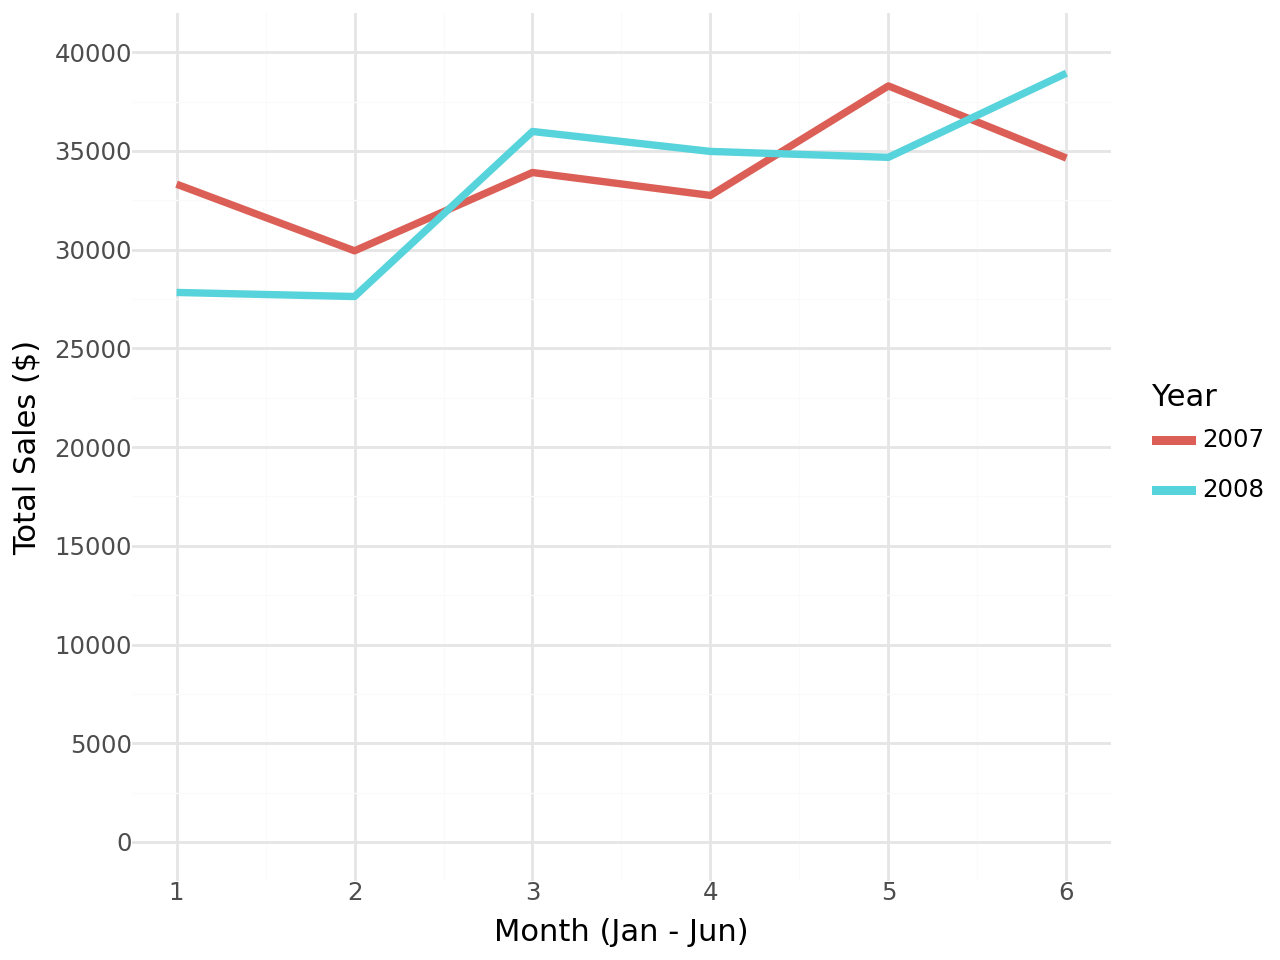

In [20]:
e01_YoY_df['SHOP_MONTH'] = pd.to_datetime(e01_YoY_df['SHOP_DATE'], format='%Y-%m-%d').dt.month
e01_YoY_df = e01_YoY_df[e01_YoY_df['SHOP_MONTH'].between(1, 6)]
monthly_sales_df = e01_YoY_df.groupby(['SHOP_MONTH', 'SHOP_YEAR']).agg({'TOTAL_SALES': 'sum'}).reset_index()

plot = (ggplot(monthly_sales_df, aes(x='SHOP_MONTH', y='TOTAL_SALES', color='SHOP_YEAR', group='SHOP_YEAR')) +
        geom_line(size=1.5) +
        scale_x_continuous(breaks=[1, 2, 3, 4, 5, 6]) +
        scale_y_continuous(breaks =  [0,5000,10000,15000,20000,25000,30000,35000,40000], limits = [0,40000]) +
        labs(
        #     title='Mid-Year YoY Total Sales for Berlin Store (E01)',
             x='Month (Jan - Jun)',
             y='Total Sales ($)',
             color='Year') +
        theme_minimal())
plot.show()
plot.save(filename='../figures/mid_year_YoY_Berlin_store_2.png', width=10, height=5, dpi=300, verbose=False)

In [21]:
monthly_sales_df

,SHOP_MONTH,SHOP_YEAR,TOTAL_SALES
0,1,2007,33318.74
1,1,2008,27833.51
2,2,2007,29942.86
3,2,2008,27627.10
4,3,2007,33909.73
5,3,2008,35987.65
6,4,2007,32750.57
7,4,2008,34977.99
8,5,2007,38295.37
9,5,2008,34677.93


**Determine if the total sales share a similar trend Jan - May before June campaign**

In [22]:
e01_YoY_trend = e01_YoY_df[e01_YoY_df['SHOP_MONTH'].between(1, 5)]
monthly_sales_trend = e01_YoY_trend.groupby(['SHOP_MONTH', 'SHOP_YEAR']).agg({'TOTAL_SALES': 'sum'}).reset_index()
pivot_sales = monthly_sales_trend.pivot(index='SHOP_MONTH', columns='SHOP_YEAR', values='TOTAL_SALES')
# correlation test
correlation = pivot_sales.corr().iloc[0, 1]
print(f"Pearson Correlation between 2007 and 2008 Mid-Year Sales Trends before campaign: {correlation:.2f}")

# Paired t-test on monthly total sales 
t_stat, p_value = ttest_rel(pivot_sales['2007'].dropna(), pivot_sales['2008'].dropna())
print(f"Paired T-Test: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")

Pearson Correlation between 2007 and 2008 Mid-Year Sales Trends before campaign: 0.57
Paired T-Test: t-statistic = 0.92, p-value = 0.4091


Conclusion: Through visual, and statistical tests, the mid-year YoY trend are generally similar between 2007 and 2008 before the promotion got run in June 2008

**2. Store summary during Promotion Period**

**Berlin store E01**

In [23]:
full_data_df.head()

,CUST_CODE,PROD_CODE,SPEND,QUANTITY,BASKET_ID,STORE_CODE,SHOP_DATE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_LIFESTAGE,SHOP_MONTH,SHOP_MONTH_NUM,SHOP_YEAR,TOTAL_SALES
0,CUST0000291884,PRD0903750,1.57,1,994100100327348,E01,2006-04-10,CL00075,DEP00022,G00007,D00002,OF,2006-04,4,2006,1.57
1,CUST0000928648,PRD0901098,0.84,1,994100100709841,E03,2006-04-10,CL00089,DEP00025,G00008,D00002,YA,2006-04,4,2006,0.84
2,CUST0000928411,PRD0901383,0.40,1,994100100709694,E03,2006-04-10,CL00044,DEP00011,G00004,D00002,OT,2006-04,4,2006,0.40
3,CUST0000928411,PRD0901769,1.06,1,994100100709694,E03,2006-04-10,CL00007,DEP00003,G00002,D00001,OT,2006-04,4,2006,1.06
4,CUST0000928411,PRD0901850,0.88,1,994100100709694,E03,2006-04-10,CL00162,DEP00055,G00016,D00003,OT,2006-04,4,2006,0.88


In [24]:
# Berlin store (E01) performance during promotion period (June 2008)
promo_e01_df = full_data_df[(full_data_df['STORE_CODE'] == 'E01') & 
                      (full_data_df['SHOP_YEAR'] == '2008') & 
                      (full_data_df['SHOP_MONTH'] == '2008-06')].reset_index(drop=True)
promo_e01_df['SHOP_MONTH_NUM'] = pd.to_datetime(promo_e01_df['SHOP_DATE'], format='%Y-%m-%d').dt.month
# Calculate summary metrics
e01_summary = {}

# Total Sales
e01_summary['Total Sales'] = promo_e01_df['TOTAL_SALES'].sum()

# Average Transaction Value
e01_summary['Average Spend per Transaction'] = promo_e01_df.groupby('BASKET_ID')['TOTAL_SALES'].sum().mean()

# Average Spend per Customer
e01_summary['Average Spend per Loyalty Customer'] = promo_e01_df.groupby('CUST_CODE')['TOTAL_SALES'].sum().mean()

# Total Transactions amount
e01_summary['Total Transactions'] = promo_e01_df['BASKET_ID'].nunique()

# customer life stage summary
basket_level_sales = promo_e01_df.groupby(['CUST_CODE','BASKET_ID', 'CUST_LIFESTAGE']).agg(
    basket_total_sales=('TOTAL_SALES', 'sum')
).reset_index()

# average transaction value (basket size) for each customer lifestage
lifestage_summary = basket_level_sales.groupby('CUST_LIFESTAGE').agg(
    total_sales=('basket_total_sales', 'sum'),   # Sum of all basket sales for each lifestage
    avg_basket_size=('basket_total_sales', 'mean'),  # Average basket size per transaction
    unique_customers=('CUST_CODE', pd.Series.nunique)  # Unique number of baskets
).reset_index()


# Loyalty vs. Non-Loyalty Member Analysis
loyalty_summary = promo_e01_df.groupby('CUST_CODE').agg(
    total_sales=('TOTAL_SALES', 'sum'),
    avg_basket_size=('TOTAL_SALES', 'mean')
).reset_index()

# Calculate proportions
loyalty_customers = promo_e01_df[promo_e01_df['CUST_CODE'].notnull()]['CUST_CODE'].nunique()
# Assuming all non-loyalty customers made only one purchase during promotion period
non_loyalty_customers = promo_e01_df[promo_e01_df['CUST_CODE'].isnull()]['BASKET_ID'].nunique()
total_customers = loyalty_customers + non_loyalty_customers

e01_summary['Total Customer'] = total_customers
e01_summary['Loyalty Customers'] = loyalty_customers
e01_summary['Non-Loyalty Customers'] = non_loyalty_customers
e01_summary['Proportion of Sales from Loyalty Members'] = promo_e01_df[promo_e01_df['CUST_CODE'].notnull()]['TOTAL_SALES'].sum() / e01_summary['Total Sales']
e01_summary['Loyalty Member Proportion'] = round(100 * loyalty_customers / total_customers,2)
e01_summary['Non-Loyalty Member Proportion'] = round(100 * non_loyalty_customers / total_customers,2)

# new loyalty customers
e01_promo_loyalty = promo_e01_df[promo_e01_df['CUST_CODE'].notnull()]

# E01 loyalty member data before promo
e01_before_promo = full_data_df[(full_data_df['STORE_CODE'] == 'E01') & 
                                    (full_data_df['SHOP_YEAR'] == '2008') & 
                                    (full_data_df['SHOP_MONTH_NUM'] < 6) &
                                    (full_data_df['CUST_CODE'].notnull())]
# new customer df
e01_new_customers_promo = e01_promo_loyalty[~e01_promo_loyalty['CUST_CODE'].isin(e01_before_promo['CUST_CODE'])]

# e01_new_customers_promo['CUST_CODE'].nunique()

# Convert summary to a dataframe for easy visualization
e01_summary_df = pd.DataFrame(e01_summary.items(), columns=['Performance_Metric', 'E01_Value'])

In [25]:
# New Loyalty Customers Lifestage Summary
new_customer_lifestage_summary = e01_new_customers_promo.groupby('CUST_LIFESTAGE').agg(
    num_new_customers=('CUST_CODE', pd.Series.nunique),
    total_sales=('TOTAL_SALES', 'sum'),
).reset_index()

new_customer_lifestage_summary['proportion_of_new_customers'] = (new_customer_lifestage_summary['num_new_customers'] / 
                                                                 new_customer_lifestage_summary['num_new_customers'].sum()) * 100
new_customer_lifestage_summary

,CUST_LIFESTAGE,num_new_customers,total_sales,proportion_of_new_customers
0,OA,31,477.49,10.915493
1,OF,12,394.68,4.225352
2,OT,115,1942.86,40.492958
3,PE,24,2242.45,8.450704
4,YA,47,741.10,16.549296
5,YF,55,1601.32,19.366197


In [26]:
# E01 summary during promotion period
e01_summary_df

,Performance_Metric,E01_Value
0,Total Sales,38940.440000
1,Average Spend per Transaction,12.272436
2,Average Spend per Loyalty Customer,42.279391
3,Total Transactions,3173.000000
4,Total Customer,1353.000000
5,Loyalty Customers,690.000000
6,Non-Loyalty Customers,663.000000
7,Proportion of Sales from Loyalty Members,0.749164
8,Loyalty Member Proportion,51.000000
9,Non-Loyalty Member Proportion,49.000000


In [27]:
# E01 overall lifestage summary
lifestage_summary['proportion_of_customers'] = (lifestage_summary['unique_customers'] / 
                                                                 lifestage_summary['unique_customers'].sum()) * 100
lifestage_summary

,CUST_LIFESTAGE,total_sales,avg_basket_size,unique_customers,proportion_of_customers
0,OA,2647.74,10.302490,72,11.881188
1,OF,1736.86,12.677810,32,5.280528
2,OT,7654.28,10.616200,228,37.623762
3,PE,3388.94,16.944700,47,7.755776
4,YA,4350.37,9.887205,111,18.316832
5,YF,6038.93,13.819062,116,19.141914


In [28]:
new_customer_lifestage_summary

,CUST_LIFESTAGE,num_new_customers,total_sales,proportion_of_new_customers
0,OA,31,477.49,10.915493
1,OF,12,394.68,4.225352
2,OT,115,1942.86,40.492958
3,PE,24,2242.45,8.450704
4,YA,47,741.10,16.549296
5,YF,55,1601.32,19.366197


In [29]:
# Budapest store (E03) performance during promotion period (June 2008)
promo_e03_df = full_data_df[(full_data_df['STORE_CODE'] == 'E03') & 
                      (full_data_df['SHOP_YEAR'] == '2008') & 
                      (full_data_df['SHOP_MONTH'] == '2008-06')].reset_index(drop=True)
promo_e03_df['SHOP_MONTH_NUM'] = pd.to_datetime(promo_e03_df['SHOP_DATE'], format='%Y-%m-%d').dt.month
# Calculate summary metrics
e03_summary = {}

# Total Sales
e03_summary['Total Sales'] = promo_e03_df['TOTAL_SALES'].sum()

# Average Basket Size
e03_summary['Average Spend per Transaction'] = promo_e03_df.groupby('BASKET_ID')['TOTAL_SALES'].sum().mean()

# Average Spend per Customer
e03_summary['Average Spend per Loyalty Customer'] = promo_e03_df.groupby('CUST_CODE')['TOTAL_SALES'].sum().mean()

# Total Transactions amount
e03_summary['Total Transactions'] = promo_e03_df['BASKET_ID'].nunique()

# customer life stage summary
basket_level_sales = promo_e03_df.groupby(['CUST_CODE','BASKET_ID', 'CUST_LIFESTAGE']).agg(
    basket_total_sales=('TOTAL_SALES', 'sum')
).reset_index()

lifestage_summary_e03 = basket_level_sales.groupby('CUST_LIFESTAGE').agg(
    total_sales=('basket_total_sales', 'sum'),   # Sum of all basket sales for each lifestage
    avg_basket_size=('basket_total_sales', 'mean'),  # Average basket size per transaction
    unique_customers=('CUST_CODE', pd.Series.nunique)  # Unique number of baskets
).reset_index()


# Loyalty vs. Non-Loyalty Member Analysis
loyalty_summary = promo_e03_df.groupby('CUST_CODE').agg(
    total_sales=('TOTAL_SALES', 'sum'),
    avg_basket_size=('TOTAL_SALES', 'mean')
).reset_index()

# Calculate proportions
loyalty_customers = promo_e03_df[promo_e03_df['CUST_CODE'].notnull()]['CUST_CODE'].nunique()
# Assuming all non-loyalty customers made only one purchase during promotion period
non_loyalty_customers = promo_e03_df[promo_e03_df['CUST_CODE'].isnull()]['BASKET_ID'].nunique()
total_customers = loyalty_customers + non_loyalty_customers

e03_summary['Total Customer'] = total_customers
e03_summary['Loyalty Customers'] = loyalty_customers
e03_summary['Non-Loyalty Customers'] = non_loyalty_customers
e03_summary['Proportion of Sales from Loyalty Members'] = promo_e03_df[promo_e03_df['CUST_CODE'].notnull()]['TOTAL_SALES'].sum() / e03_summary['Total Sales']
e03_summary['Loyalty Member Proportion'] = round(100 * loyalty_customers / total_customers,2)
e03_summary['Non-Loyalty Member Proportion'] = round(100 * non_loyalty_customers / total_customers,2)

# new loyalty customers
e03_promo_loyalty = promo_e03_df[promo_e03_df['CUST_CODE'].notnull()]

# E01 loyalty member data before promo
e03_before_promo = full_data_df[(full_data_df['STORE_CODE'] == 'E03') & 
                                    (full_data_df['SHOP_YEAR'] == '2008') & 
                                    (full_data_df['SHOP_MONTH_NUM'] < 6) &
                                    (full_data_df['CUST_CODE'].notnull())]
# new customer df
e03_new_customers_promo = e03_promo_loyalty[~e03_promo_loyalty['CUST_CODE'].isin(e03_before_promo['CUST_CODE'])]

e03_new_customers_promo['CUST_CODE'].nunique()

# Convert summary to a dataframe for easy visualization
e03_summary_df = pd.DataFrame(e03_summary.items(), columns=['Performance_Metric', 'E03_Value'])

In [30]:
e03_new_customers_promo['CUST_CODE'].nunique()

49

#### Accessing if E03 is a valid control group, by comparing sales summary in May. If two stores are sharing similar characteristics, consider using Difference-in-Difference methods that compares changes in outcomes (running promotion) over time between Berlin store (the treatment group) and Budapest store (the comparison group)

In [31]:
def calculate_store_summary(full_data_df, store_code, year, month):
    """Function to calculate the summary table based on store, year, and month"""
    # Filter data for the specified store, year, and month
    pre_store_df = full_data_df[(full_data_df['STORE_CODE'] == store_code) & 
                                (full_data_df['SHOP_YEAR'] == year) & 
                                (full_data_df['SHOP_MONTH'] == month)].reset_index(drop=True)
    
    # Add month number if needed
    pre_store_df['SHOP_MONTH_NUM'] = pd.to_datetime(pre_store_df['SHOP_DATE'], format='%Y-%m-%d').dt.month

    # Calculate summary metrics
    pre_store_summary = {}

    # Total Sales
    pre_store_summary['Total Sales'] = pre_store_df['TOTAL_SALES'].sum()

    # Average Transaction Value
    pre_store_summary['Average Spend per Transaction'] = pre_store_df.groupby('BASKET_ID')['TOTAL_SALES'].sum().mean()

    # Average Spend per Loyalty Customer
    pre_store_summary['Average Spend per Loyalty Customer'] = pre_store_df.groupby('CUST_CODE')['TOTAL_SALES'].sum().mean()

    # Total Transactions amount
    pre_store_summary['Total Transactions'] = pre_store_df['BASKET_ID'].nunique()

    # Lifestage Summary
    basket_level_sales = pre_store_df.groupby(['CUST_CODE','BASKET_ID', 'CUST_LIFESTAGE']).agg(
        basket_total_sales=('TOTAL_SALES', 'sum')
    ).reset_index()

    lifestage_summary = basket_level_sales.groupby('CUST_LIFESTAGE').agg(
        total_sales=('basket_total_sales', 'sum'),   # Sum of all basket sales for each lifestage
        avg_basket_size=('basket_total_sales', 'mean'),  # Average basket size per transaction
        unique_customers=('CUST_CODE', pd.Series.nunique)  # Unique number of customers
    ).reset_index()

    # Loyalty vs. Non-Loyalty Member Analysis
    loyalty_customers = pre_store_df[pre_store_df['CUST_CODE'].notnull()]['CUST_CODE'].nunique()
    non_loyalty_customers = pre_store_df[pre_store_df['CUST_CODE'].isnull()]['BASKET_ID'].nunique()
    total_customers = loyalty_customers + non_loyalty_customers

    pre_store_summary['Total Customers'] = total_customers
    pre_store_summary['Loyalty Customers'] = loyalty_customers
    pre_store_summary['Non-Loyalty Customers'] = non_loyalty_customers
    pre_store_summary['Proportion of Sales from Loyalty Members'] = pre_store_df[pre_store_df['CUST_CODE'].notnull()]['TOTAL_SALES'].sum() / pre_store_summary['Total Sales']
    pre_store_summary['Loyalty Member Proportion'] = round(100 * loyalty_customers / total_customers, 2)
    pre_store_summary['Non-Loyalty Member Proportion'] = round(100 * non_loyalty_customers / total_customers, 2)

    # Convert the summary to a dataframe
    return pd.DataFrame(pre_store_summary.items(), columns=['Performance_Metric', f'{store_code}_Value']), lifestage_summary

In [32]:
# Calculate summaries for E03 and E01
# Budapest store (E03) and Berlin store (E01) before promotion
pre_e03_summary_df, pre_lifestage_summary_e03 = calculate_store_summary(full_data_df, 'E03', year='2008', month='2008-05')
pre_e01_summary_df, pre_lifestage_summary_e01 = calculate_store_summary(full_data_df, 'E01', year='2008', month='2008-05')

# Comparison of E03 and E01 before promo
comparison_df_before_promo = pd.merge(pre_e03_summary_df, pre_e01_summary_df, on='Performance_Metric')

In [33]:
new_customer_lifestage_summary

,CUST_LIFESTAGE,num_new_customers,total_sales,proportion_of_new_customers
0,OA,31,477.49,10.915493
1,OF,12,394.68,4.225352
2,OT,115,1942.86,40.492958
3,PE,24,2242.45,8.450704
4,YA,47,741.10,16.549296
5,YF,55,1601.32,19.366197


In [34]:
lifestage_summary

,CUST_LIFESTAGE,total_sales,avg_basket_size,unique_customers,proportion_of_customers
0,OA,2647.74,10.302490,72,11.881188
1,OF,1736.86,12.677810,32,5.280528
2,OT,7654.28,10.616200,228,37.623762
3,PE,3388.94,16.944700,47,7.755776
4,YA,4350.37,9.887205,111,18.316832
5,YF,6038.93,13.819062,116,19.141914


In [35]:
# proportion of pre-promotion vs promotion life stage relatively similar, suggesting that the promotion did not target a specific lifestage 
pre_lifestage_summary_e01['proportion_of_customers'] = (pre_lifestage_summary_e01['unique_customers'] / 
                                                                 pre_lifestage_summary_e01['unique_customers'].sum()) * 100
pre_lifestage_summary_e01

,CUST_LIFESTAGE,total_sales,avg_basket_size,unique_customers,proportion_of_customers
0,OA,2229.55,19.557456,36,11.464968
1,OF,1855.96,25.777222,20,6.369427
2,OT,7341.31,23.991209,119,37.898089
3,PE,1221.07,12.588351,20,6.369427
4,YA,3957.57,15.399105,68,21.656051
5,YF,4564.15,28.000920,51,16.242038


**proportion of pre-promotion vs promotion life stage relatively similar, suggesting that the promotion did not target a specific lifestage**

In [36]:
comparison_df_before_promo

,Performance_Metric,E03_Value,E01_Value
0,Total Sales,33491.730000,34677.930000
1,Average Spend per Transaction,24.735399,23.866435
2,Average Spend per Loyalty Customer,72.455915,68.726878
3,Total Transactions,1354.000000,1453.000000
4,Total Customers,634.000000,629.000000
5,Loyalty Customers,355.000000,362.000000
6,Non-Loyalty Customers,279.000000,267.000000
7,Proportion of Sales from Loyalty Members,0.768006,0.717434
8,Loyalty Member Proportion,55.990000,57.550000
9,Non-Loyalty Member Proportion,44.010000,42.450000


**Conduct Statistical Test to evaluate if the Berlin and Budapest are similar so Budapest can be set as a control group**

In [37]:
pre_e01_df = full_data_df[(full_data_df['STORE_CODE'] == 'E01') & 
                          (full_data_df['SHOP_YEAR'] == '2008') & 
                          (full_data_df['SHOP_MONTH'] == '2008-05')].reset_index(drop=True)

pre_e03_df = full_data_df[(full_data_df['STORE_CODE'] == 'E03') & 
                          (full_data_df['SHOP_YEAR'] == '2008') & 
                          (full_data_df['SHOP_MONTH'] == '2008-05')].reset_index(drop=True)

In [38]:
# t-test for transaction value
basket_size_e03 = pre_e03_df.groupby('BASKET_ID')['TOTAL_SALES'].sum()
basket_size_e01 = pre_e01_df.groupby('BASKET_ID')['TOTAL_SALES'].sum()
t_stat, p_val_ttest = ttest_ind(basket_size_e03, basket_size_e01, equal_var=False)
print(f"T-Test for Transaction Value: t-statistic = {t_stat:.2f}, p-value = {p_val_ttest:.4f}")

T-Test for Transaction Value: t-statistic = 0.41, p-value = 0.6850


In [39]:
# ks test for distribution of total sales per transaction
ks_stat, p_val_ks = ks_2samp(basket_size_e01, basket_size_e03)
print(f"KS Test for Distribution of Total Sales per Transaction: KS-statistic = {ks_stat:.2f}, p-value = {p_val_ks:.4f}")

KS Test for Distribution of Total Sales per Transaction: KS-statistic = 0.03, p-value = 0.7470


In [40]:
# chi-square test for lifestage distribution
# Note: for sake of test, only consider known lifestages
lifestage_e03 = pre_e03_df['CUST_LIFESTAGE'].value_counts()
lifestage_e01 = pre_e01_df['CUST_LIFESTAGE'].value_counts()
lifestage_df = pd.DataFrame({'E03': lifestage_e03, 'E01': lifestage_e01}).fillna(0)
chi2_stat, p_val_chi2, dof, expected = chi2_contingency(lifestage_df)
print(f"Chi-Square Test for Customer Lifestage Distribution: chi2 = {chi2_stat:.2f}, p-value = {p_val_chi2:.4f}")

Chi-Square Test for Customer Lifestage Distribution: chi2 = 644.88, p-value = 0.0000


In [41]:
# Berlin store has more old family and young adult customers, while Budapest store has more other and older adult customers
lifestage_df

,E03,E01
CUST_LIFESTAGE,,
OA,813,682
OF,129,541
OT,2426,1830
PE,476,526
YA,701,1536
YF,1400,1332


In [42]:
# Proportional Z-Test for loyalty customer proportions
loyalty_pre_e03 = pre_e03_df[pre_e03_df['CUST_CODE'].notnull()]['CUST_CODE'].nunique()
non_loyalty_pre_e03 = pre_e03_df[pre_e03_df['CUST_CODE'].isnull()]['BASKET_ID'].nunique()
total_pre_e03 = loyalty_pre_e03 + non_loyalty_pre_e03

loyalty_pre_e01 = pre_e01_df[pre_e01_df['CUST_CODE'].notnull()]['CUST_CODE'].nunique()
non_loyalty_pre_e01 = pre_e01_df[pre_e01_df['CUST_CODE'].isnull()]['BASKET_ID'].nunique()
total_pre_e01 = loyalty_pre_e01 + non_loyalty_pre_e01

z_stat, p_val_ztest = proportions_ztest([loyalty_pre_e03, loyalty_pre_e01], [total_pre_e03, total_pre_e01])
print(f"Proportional Z-Test for Loyalty vs. Non-Loyalty Customers: z-statistic = {z_stat:.2f}, p-value = {p_val_ztest:.4f}")

Proportional Z-Test for Loyalty vs. Non-Loyalty Customers: z-statistic = -0.56, p-value = 0.5763


**Conclusion: Despite customer lifestage are having different distribution, all other key metrics suggest that Berlin store and Budapest store share statistically similar characteristics. So Budapest can be considered as a valid control group before promotion**

#### Use Difference-in-difference methods to estimate the causal effect of the promotion by comparing the changes in outcomes overtime between Berlin (E01) and Budapest (E03).

In [43]:
full_data_df.head()

,CUST_CODE,PROD_CODE,SPEND,QUANTITY,BASKET_ID,STORE_CODE,SHOP_DATE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_LIFESTAGE,SHOP_MONTH,SHOP_MONTH_NUM,SHOP_YEAR,TOTAL_SALES
0,CUST0000291884,PRD0903750,1.57,1,994100100327348,E01,2006-04-10,CL00075,DEP00022,G00007,D00002,OF,2006-04,4,2006,1.57
1,CUST0000928648,PRD0901098,0.84,1,994100100709841,E03,2006-04-10,CL00089,DEP00025,G00008,D00002,YA,2006-04,4,2006,0.84
2,CUST0000928411,PRD0901383,0.40,1,994100100709694,E03,2006-04-10,CL00044,DEP00011,G00004,D00002,OT,2006-04,4,2006,0.40
3,CUST0000928411,PRD0901769,1.06,1,994100100709694,E03,2006-04-10,CL00007,DEP00003,G00002,D00001,OT,2006-04,4,2006,1.06
4,CUST0000928411,PRD0901850,0.88,1,994100100709694,E03,2006-04-10,CL00162,DEP00055,G00016,D00003,OT,2006-04,4,2006,0.88


In [44]:
# base df for DiD analysis
pre_post_df = full_data_df[(full_data_df['SHOP_YEAR'] == '2008') & 
                           (full_data_df['SHOP_MONTH_NUM'].isin([5, 6])) & 
                           (full_data_df['STORE_CODE'].isin(['E01', 'E03']))]

In [45]:
# total sales for each store and period
sales_summary = pre_post_df.groupby(['STORE_CODE', 'SHOP_MONTH_NUM']).agg(
    total_sales=('TOTAL_SALES', 'sum'),
    # avg_basket_size=('TOTAL_SALES', 'mean'),
    transaction_count=('BASKET_ID', 'nunique')
).reset_index()

# period and treated variables
sales_summary['period'] = sales_summary['SHOP_MONTH_NUM'].apply(lambda x: 1 if x == 6 else 0)  # 1: promotion (June), 0: pre-promotion (May)
sales_summary['treated'] = sales_summary['STORE_CODE'].apply(lambda x: 1 if x == 'E01' else 0)  # 1: E01 (treatment), 0: E03 (control)

# Difference-in-Difference model
did_total_sales = smf.ols('total_sales ~ treated + period + treated*period', data=sales_summary).fit()

print(did_total_sales.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sales   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 02 Oct 2024   Prob (F-statistic):                nan
Time:                        07:29:14   Log-Likelihood:                 92.815
No. Observations:                   4   AIC:                            -177.6
Df Residuals:                       0   BIC:                            -180.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.349e+04        inf        

d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide


In [46]:
# as monthly aggregation would only have 4 observations, we can also perform DiD analysis on daily data to validate the results is significant (p-value will be available)
# Demonstration purpose, still use monthly data for result delivery
pre_post_daily_df = pre_post_df.groupby(['STORE_CODE', 'SHOP_DATE']).agg(
    total_sales=('TOTAL_SALES', 'sum')
).reset_index()

# Daily level data to increase number of observations, for sake of test, did not include week of the day or other additional covariates to access the impact of promotion
pre_post_daily_df['period'] = pre_post_daily_df['SHOP_DATE'].apply(lambda x: 1 if pd.to_datetime(x).month == 6 else 0)  # June = post-promotion
pre_post_daily_df['treated'] = pre_post_daily_df['STORE_CODE'].apply(lambda x: 1 if x == 'E01' else 0)

# Step 3: Fit the DiD model on daily data
did_sales_daily = smf.ols('total_sales ~ treated + period + treated*period', data=pre_post_daily_df).fit()

# Display the summary
print(did_sales_daily.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sales   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.906
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.132
Time:                        07:29:21   Log-Likelihood:                -902.30
No. Observations:                 122   AIC:                             1813.
Df Residuals:                     118   BIC:                             1824.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1080.3784     71.996     15.

In [47]:
# transaction count
did_transaction = smf.ols('transaction_count ~ treated + period + treated*period', data=sales_summary).fit()
print(did_transaction.summary())

                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 02 Oct 2024   Prob (F-statistic):                nan
Time:                        07:29:24   Log-Likelihood:                 105.17
No. Observations:                   4   AIC:                            -202.3
Df Residuals:                       0   BIC:                            -204.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1354.0000        inf        

d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide


In [48]:
# 
sales_summary_per_basket = pre_post_df.groupby(['STORE_CODE','BASKET_ID', 'SHOP_MONTH_NUM']).agg(
    sales_per_transaction=('TOTAL_SALES', 'sum')
).reset_index()
sales_basket = sales_summary_per_basket.groupby(['STORE_CODE', 'SHOP_MONTH_NUM']).agg(
    avg_basket_size=('sales_per_transaction', 'mean')
).reset_index()

# period and treated variables
sales_basket['period'] = sales_basket['SHOP_MONTH_NUM'].apply(lambda x: 1 if x == 6 else 0)  # 1: promotion (June), 0: pre-promotion (May)
sales_basket['treated'] = sales_basket['STORE_CODE'].apply(lambda x: 1 if x == 'E01' else 0)  # 1: E01 (treatment), 0: E03 (control)

did_sales_basket = smf.ols('avg_basket_size ~ treated + period + treated*period', data=sales_basket).fit()
print(did_sales_basket.summary())

                            OLS Regression Results                            
Dep. Variable:        avg_basket_size   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 02 Oct 2024   Prob (F-statistic):                nan
Time:                        07:29:29   Log-Likelihood:                 122.69
No. Observations:                   4   AIC:                            -237.4
Df Residuals:                       0   BIC:                            -239.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         24.7354        inf        

d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
d:\Efficiency_softwares\Anaconda_2024\Lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide


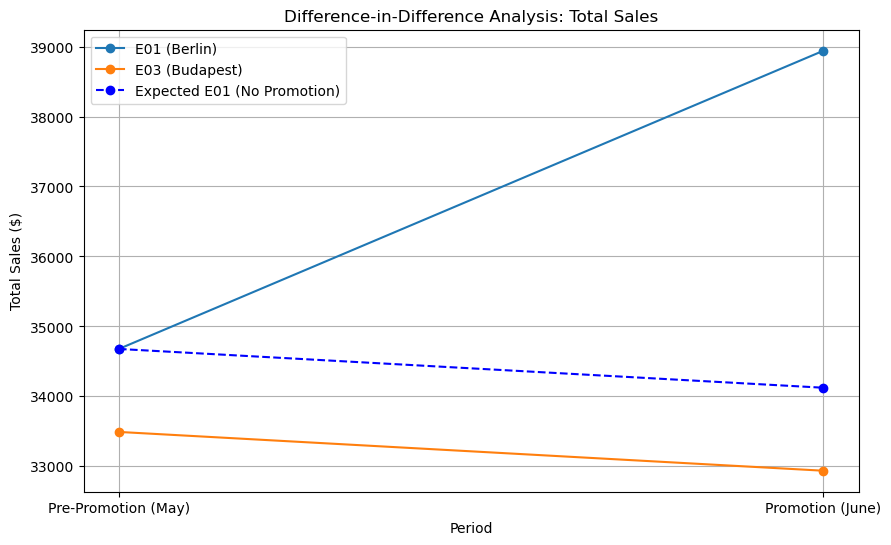

In [49]:
# DiD visual
sales_pivot = sales_summary.pivot(index='period', columns='STORE_CODE', values='total_sales')

pre_promotion_diff = sales_pivot.loc[0, 'E01'] - sales_pivot.loc[0, 'E03']

# Calculate the expected post-promotion sales for E01 assuming no promotion
expected_e01_post_promo = sales_pivot.loc[1, 'E03'] + pre_promotion_diff

# Plot the trends for E01 and E03
plt.figure(figsize=(10, 6))
plt.plot(sales_pivot.index, sales_pivot['E01'], marker='o', label='E01 (Berlin)')
plt.plot(sales_pivot.index, sales_pivot['E03'], marker='o', label='E03 (Budapest)')
# normal trend for E01 (no promotion)
plt.plot([0, 1], [sales_pivot.loc[0, 'E01'], expected_e01_post_promo], marker='o', linestyle='--', color='blue', label='Expected E01 (No Promotion)')

plt.xticks([0, 1], ['Pre-Promotion (May)', 'Promotion (June)'])
plt.xlabel('Period')
plt.ylabel('Total Sales ($)')
plt.title('Difference-in-Difference Analysis: Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# calculate the increase of new customers
prop_new_cust_e01 = e01_new_customers_promo['CUST_CODE'].nunique() / promo_e01_df[promo_e01_df['CUST_CODE'].notnull()]['CUST_CODE'].nunique()
prop_new_cust_e03 = e03_new_customers_promo['CUST_CODE'].nunique() / promo_e03_df[promo_e03_df['CUST_CODE'].notnull()]['CUST_CODE'].nunique()

# proportion of new customers
new_customer_diff = (prop_new_cust_e01 - prop_new_cust_e03) / prop_new_cust_e03
print(e01_new_customers_promo['CUST_CODE'].nunique())
print(new_customer_diff)

325
2.393226855959775


**DiD Conclusion: Running the promotion leads to around $4816.97 increase in total sales, increase of 1,760 transactions, and around $11.9 less spend per transaction, and 239% more loyalty member purchase during the promotion month**

## How Points got calculated:
Loyalty members receive a base offer of 1 point for every $10 spent in store.  For example, if a person spends $18 in store one day, and $35 the next, they would earn 1 point the first day and 3 points the following day. For ease of calculations, assume an additional 10% of points were issued as bonus points from various promotions. A total of 1,500 customers redeemed 150,000 points in 2007, for $1,500 off their groceries.

**Aggregate points by customer and and date for points redeemed by each customer for each day**

In [52]:
# calculate the points redeemed by customers during the promotion period
e01_promo_points = promo_e01_df[promo_e01_df['CUST_CODE'].notnull()].groupby(['CUST_CODE', 'SHOP_DATE']).agg({'TOTAL_SALES': 'sum'}).reset_index()
e01_promo_points['POINTS_REDEEMED'] = np.floor(e01_promo_points['TOTAL_SALES'] / 10)
e01_promo_points.head()

,CUST_CODE,SHOP_DATE,TOTAL_SALES,POINTS_REDEEMED
0,CUST0000004457,2008-06-19,0.56,0.0
1,CUST0000005388,2008-06-10,2.33,0.0
2,CUST0000006445,2008-06-01,1.66,0.0
3,CUST0000006445,2008-06-15,0.97,0.0
4,CUST0000006445,2008-06-17,7.33,0.0


In [53]:
# TOTAL POINTS REDEEMED
e01_promo_points['POINTS_REDEEMED'].sum() * 1.1

2355.1000000000004

#### WIP Area:

In [122]:
# Assuming all non-loyalty customers made only one purchase during promotion period
non_loyalty_customers = promo_e01_df[promo_e01_df['CUST_CODE'].isnull()]['BASKET_ID'].nunique()

663

In [116]:
# E01 loyalty members
e01_promo_loyalty = promo_e01_df[promo_e01_df['CUST_CODE'].notnull()]

# E01 loyalty member data before promo
e01_before_promo = full_data_df[(full_data_df['STORE_CODE'] == 'E01') & 
                                    (full_data_df['SHOP_YEAR'] == '2008') & 
                                    (full_data_df['SHOP_MONTH_NUM'] < 6) &
                                    (full_data_df['CUST_CODE'].notnull())]
# new customer df
e01_new_customers_promo = e01_promo_loyalty[~e01_promo_loyalty['CUST_CODE'].isin(e01_before_promo['CUST_CODE'])]

e01_new_customers_promo['CUST_CODE'].nunique()

325

In [26]:
cust_spend_summary = full_data_df[full_data_df['SHOP_MONTH'] == '2008-07'].groupby(['CUST_CODE', 'BASKET_ID', 'SHOP_DATE']).agg(
    total_sales = ('TOTAL_SALES', 'sum'),
    # sales_date = ('SHOP_DATE', 'first'),
    # trans_sales=('BASKET_ID', 'sum'),
    # total_quantity=('QUANTITY', 'sum'),
    # avg_spend_per_prod=('SPEND', 'mean'),
    # unique_customers=('CUST_CODE', pd.Series.nunique)  # Count unique customers
).reset_index()

In [25]:
# Group by `PROD_CODE_10` and calculate aggregates
prod_code_10_summary = data_2008.groupby('PROD_CODE_10').agg(
    total_sales=('TOTAL_SALES', 'sum'),
    total_quantity=('QUANTITY', 'sum'),
    avg_spend_per_prod=('SPEND', 'mean'),
    unique_customers=('CUST_CODE', pd.Series.nunique)  # Count unique customers
).reset_index()

# Display the result
prod_code_10_summary.head()

,PROD_CODE_10,total_sales,total_quantity,avg_spend_per_prod,unique_customers
0,CL00001,29396.26,14093,1.370111,1719
1,CL00002,22854.16,10759,1.385493,1574
2,CL00003,11273.67,5263,1.393413,1069
3,CL00004,2195.32,1033,1.709169,281
4,CL00005,4939.81,2304,1.579735,619


In [22]:
full_data_df['PROD_CODE_10'].nunique()

250

In [20]:
full_data_df.dtypes

CUST_CODE                object
PROD_CODE                object
SPEND                   float64
QUANTITY                  int64
BASKET_ID                 int64
STORE_CODE               object
SHOP_DATE                object
PROD_CODE_10             object
PROD_CODE_20             object
PROD_CODE_30             object
PROD_CODE_40             object
CUST_LIFESTAGE           object
SHOP_MONTH            period[M]
TOTAL_SALES             float64
SHOP_YEAR         period[A-DEC]
dtype: object

In [ ]:
full_data_df.groupby('SHOP_MONTH')['SHOP_DATE'].count()

In [16]:
full_data_df['QUANTITY'].describe()

count    3.159580e+06
mean     1.503770e+00
std      1.819382e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.685000e+03
Name: QUANTITY, dtype: float64

In [39]:
full_data_df['SHOP_MONTH'].value_counts().sort_index()

SHOP_MONTH
2006-04     78284
2006-05    118993
2006-06    117833
2006-07    122834
2006-08    118368
2006-09    117973
2006-10    117293
2006-11    115288
2006-12    118408
2007-01    116473
2007-02    108455
2007-03    121296
2007-04    117096
2007-05    120888
2007-06    119399
2007-07    122181
2007-08    121431
2007-09    117809
2007-10    117761
2007-11    115412
2007-12    116532
2008-01    113189
2008-02    109775
2008-03    117238
2008-04    115527
2008-05    120570
2008-06    119165
2008-07     24109
Freq: M, Name: count, dtype: int64